# Simulated Counts: CountsDiff vs Gaussian Diffusion

This notebook trains two simple MLP-based generative models on synthetic count data (support over natural numbers):
- CountsDiff (binomial corruption + birth/death sampling).
- Gaussian diffusion baseline (DDPM on log1p-normalized counts).

We generate Negative Binomial data, train both models, and compare sample quality (histograms and simple distances).

In [ ]:
# Setup
import math, random, os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance


# Reproducibility
seed = 42
random.seed(seed); np.random.seed(seed)
torch.manual_seed(seed);
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 1) Simulated Negative Binomial data

In [3]:
# ---------------------------
# Config
# ---------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)

N_train, N_val = 20_000, 4_000
D = 10  # dimensionality (independent genes/features)

# --- Gene-wise parameters (different for each dimension) in (mu, theta) ---
# Choose small means with heavy upper tails by keeping theta small-ish.
# Below: mu ~ log-uniform on [0.05, 5], theta ~ log-uniform on [0.2, 5].
mu_min, mu_max = 0.05, 5.0
theta_min, theta_max = 0.2, 5.0

# Sample log-uniformly to cover a broad dynamic range
mu = torch.exp(torch.rand(D) * (torch.log(torch.tensor(mu_max)) - torch.log(torch.tensor(mu_min))) 
               + torch.log(torch.tensor(mu_min)))

alpha_min, alpha_max = 0.05, 0.5   # larger alpha => more overdispersion
alpha = torch.exp(torch.rand(D) * (torch.log(torch.tensor(alpha_max)) - torch.log(torch.tensor(alpha_min)))
                  + torch.log(torch.tensor(alpha_min)))
theta = 1.0 / alpha

mu = mu.to(device)
theta = theta.to(device)

use_size_factors = True
size_factor_sigma = 0.6 

# ---------------------------
# Sampler: NB(μ, θ) via Gamma-Poisson
# ---------------------------
# NB(μ, θ) equivalence: X ~ Poisson(Λ), Λ ~ Gamma(shape=θ, rate=θ/μ)
# (PyTorch's Gamma uses 'rate' not 'scale'.)
@torch.no_grad()
def sample_nb_mu_theta(n_samples: int,
                       mu: torch.Tensor,       # [D]
                       theta: torch.Tensor,    # [D]
                       size_factors: torch.Tensor | None = None,  # [n] or [n,1]
                       device: str = "cpu") -> torch.Tensor:
    """
    Returns integer counts of shape [n_samples, D].
    """
    D = mu.shape[0]
    mu = mu.to(device)
    theta = theta.to(device)

    if size_factors is None:
        # broadcast params to [n, D]
        mu_eff = mu.unsqueeze(0).expand(n_samples, D)
    else:
        # allow size_factors shape [n] or [n,1]
        if size_factors.dim() == 1:
            s = size_factors.view(-1, 1)
        else:
            s = size_factors
        assert s.shape[0] == n_samples, "size_factors first dim must equal n_samples"
        mu_eff = s.to(device) * mu.unsqueeze(0)  # [n,1] * [1,D] -> [n,D]

    # Gamma-Poisson mixture: Gamma(shape=θ, rate=θ/μ_eff) then Poisson
    # Broadcast: concentration (shape) [1,D] -> [n,D], rate [n,D]
    conc = theta.unsqueeze(0).expand_as(mu_eff)      # shape [n, D]
    rate = theta.unsqueeze(0) / mu_eff               # shape [n, D]

    gamma = torch.distributions.Gamma(concentration=conc, rate=rate).sample()
    counts = torch.poisson(gamma)
    return counts.long()

# ---------------------------
# Generate data
# ---------------------------
def make_size_factors(n: int, sigma: float, device: str = "cpu") -> torch.Tensor:
    # LogNormal(mean=0, std=sigma)
    return torch.distributions.LogNormal(0.0, sigma).sample((n,)).to(device)

if use_size_factors:
    s_train = make_size_factors(N_train, size_factor_sigma, device=device)
    s_val   = make_size_factors(N_val,   size_factor_sigma, device=device)
else:
    s_train = s_val = None

X_train = sample_nb_mu_theta(N_train, mu, theta, s_train, device=device)
X_val   = sample_nb_mu_theta(N_val,   mu, theta, s_val,   device=device)

train_loader = DataLoader(TensorDataset(X_train), batch_size=256, shuffle=True,  drop_last=True)
val_loader   = DataLoader(TensorDataset(X_val),   batch_size=256, shuffle=False, drop_last=False)

# Peek at a few rows and per-dimension stats
print(X_train[:5])
print("per-dim mean (train):", X_train.float().mean(0))
print("per-dim var  (train):", X_train.float().var(0, unbiased=False))

tensor([[1, 1, 0, 0, 0, 1, 0, 4, 0, 2],
        [0, 0, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 5, 0, 1],
        [3, 3, 0, 1, 0, 3, 1, 6, 3, 5],
        [0, 3, 0, 0, 0, 2, 0, 3, 0, 1]], device='cuda:0')
per-dim mean (train): tensor([0.5861, 2.0444, 0.0870, 0.1049, 0.2437, 1.1112, 0.5753, 3.7003, 0.4919,
        1.0982], device='cuda:0')
per-dim var  (train): tensor([ 0.7912,  4.6947,  0.0908,  0.1122,  0.2729,  1.9742,  0.8259, 15.9150,
         0.6363,  1.8075], device='cuda:0')


In [4]:
(X_train == 0).float().mean()

tensor(0.5700, device='cuda:0')

In [5]:
max_count = X_train.max()
print(f'max count in training data: {max_count}')

max count in training data: 66


In [6]:
X_train.float().std()

tensor(1.9581, device='cuda:0')

## 2) General helpers/model definitions

In [7]:

def sinusoidal_time_embedding(t: torch.Tensor, dim: int) -> torch.Tensor:
    # t in [0,1], returns [B, dim]
    device = t.device
    half = dim // 2
    freqs = torch.exp(torch.linspace(math.log(1e-4), math.log(1.0), steps=half, device=device))
    ang = t[:, None] * freqs[None, :] * 2*math.pi
    emb = torch.cat([torch.sin(ang), torch.cos(ang)], dim=1)
    if dim % 2 == 1:
        emb = torch.cat([emb, torch.zeros((t.shape[0],1), device=device)], dim=1)
    return emb


In [8]:
class TimeMLP(nn.Module):
    def __init__(self, in_dim:int, hidden:int, out_dim:int, time_dim:int=64, n_layers:int=1):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden)
        )
        layers = []
        last = in_dim
        for i in range(n_layers):
            layers += [nn.Linear(last, hidden), nn.SiLU()]
            last = hidden
        self.backbone = nn.Sequential(*layers)
        self.proj = nn.Linear(hidden, out_dim)
        self.time_dim = time_dim

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # x: [B, D], t: [B] in [0,1]
        temb = sinusoidal_time_embedding(t, self.time_dim)
        th = self.time_mlp(temb)  # [B, hidden]
        h = self.backbone(x)      # [B, hidden]
        h = h + th
        return self.proj(h)       # [B, out_dim]

# For Gaussian DDPM we predict epsilon in log1p space
GaussianEpsModel = TimeMLP

class CategoricalTimeMLP(nn.Module):
    def __init__(self, num_classes_in: int, in_dim:int, hidden:int, out_dim:int, time_dim: int=64, num_classes_out: int = None, embed_dim: int = 64, n_layers: int = 1):
        super().__init__()
        self.embedding = nn.Embedding(num_classes_in, embed_dim)
        if num_classes_out is None:
            num_classes_out = num_classes_in
        layers = []
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden)
        )
        last_dim = in_dim * embed_dim
        for _ in range(n_layers):
            layers.extend([nn.Linear(last_dim, hidden), nn.SiLU()])
            last_dim = hidden
        self.backbone = nn.Sequential(*layers)
        self.proj = nn.Linear(hidden, num_classes_out * out_dim)
        self.time_dim = time_dim
        self.num_classes_in = num_classes_in
        self.num_classes_out = num_classes_out
        self.embed_dim = embed_dim
        self.n_dims = in_dim

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        emb = self.embedding(x.long()).view(x.shape[0], -1)
        h = self.backbone(emb)
        temb = sinusoidal_time_embedding(t, self.time_dim)
        th = self.time_mlp(temb)
        h = h + th
        logits = self.proj(h)
        return logits.view(x.shape[0], self.n_dims, self.num_classes_out)

## 3) CountsDiff: training and sampling

In [9]:
# Cosine p-scheduler used by CountsDiff
def cosine_p_scheduler(t: torch.Tensor) -> torch.Tensor:
    return torch.cos(t * math.pi / 2) ** 2

# Continuous-time weight scheduler (derivative of p)
def weight_scheduler_cosine(t: torch.Tensor) -> torch.Tensor:
    return (math.pi/2) * torch.sin(math.pi * t)

def blackout_p_scheduler(t: torch.Tensor, t_T: torch.Tensor = torch.Tensor([15.])) -> torch.Tensor:
    """Legacy blackout scheduler"""
    t_T = t_T.to(t.device)
    return torch.nn.functional.sigmoid((2*t - 1) * torch.log(torch.exp(-t_T)/(1 - torch.exp(-t_T))))

def blackout_weight_scheduler_continuous(t: torch.Tensor,  t_T: torch.Tensor = torch.Tensor([15.])) -> torch.Tensor:
    """Difference becomes derivative as we go into continuous time"""
    p_t = blackout_p_scheduler(t, t_T)
    t_T = t_T.to(p_t.device)
    return -2 * p_t * (1 - p_t) * torch.log(torch.exp(-t_T)/(1 - torch.exp(-t_T)))


# Binomial corruption (countsdiff)
def corrupt_binomial(x: torch.Tensor, t: torch.Tensor):
    # x: [B, D] counts; t: [B] in [0,1]
    B, D = x.shape
    p_t = blackout_p_scheduler(t).view(B, *([1]* (x.dim()-1)))
    x_t = torch.binomial(x.float(), p_t.expand_as(x)).to(x.dtype)
    return x_t, p_t.squeeze()

def normalize_log1p(x: torch.Tensor) -> torch.Tensor:
    return torch.log1p(x.float())

# Sigma schedule for sampling (per step)
def sigma_max(p_t: torch.Tensor, p_s: torch.Tensor) -> torch.Tensor:
    return torch.clamp((1.0 - p_s) / (p_t + 1e-12), 0.0, 1.0)

@torch.no_grad()
def eval_countsdiff(model: nn.Module, loader: DataLoader, steps:int=200) -> float:
    model.eval()
    losses=[]
    for (x,) in loader:
        x = x.to(device).long()
        B = x.shape[0]
        t = torch.rand(B, device=device)
        x_t, _ = corrupt_binomial(x, t)
        birth = (x - x_t).float()
        xin = normalize_log1p(x_t.float())
        pred = F.softplus(model(xin, t)) + 1e-8
        w = weight_scheduler_cosine(t).view(B,1)
        loss = (pred - birth * torch.log(pred)).mean(dim=1)
        loss = (w.squeeze() * loss).mean()
        losses.append(loss.item())
        if len(losses) >= steps: break
    return float(np.mean(losses)) if losses else float('nan')

@torch.no_grad()
def sample_countsdiff(model: nn.Module, n_samples:int, n_steps:int=200, D:int=1, clamp_max:int=1000, eta_rescale = 0.005, method: str = 'stochastic'
                    ):
    model.eval()
    state = torch.zeros((n_samples, D), device=device).float()
    # observation times t from 1 to 0
    ts = torch.linspace(1., 0., steps=n_steps+1, device=device)
    for i in range(n_steps):
        t = ts[i].expand(n_samples)
        s = ts[i+1].expand(n_samples)
        xin = normalize_log1p(state)
        pred = F.softplus(model(xin, t))
        # Clamp and round to valid birth counts
        pred_floor = torch.floor(pred)
        p_t = cosine_p_scheduler(t).view(-1,1)
        p_s = cosine_p_scheduler(s).view(-1,1)
        sigma = eta_rescale * sigma_max(p_t, p_s).view(-1,1)
        beta = ((p_s - (1 - sigma)*p_t) / (1 - p_t + 1e-12)).view(-1,1)
        if method == 'none':
            pred_rounded = pred.clamp(min=0.0, max=float(clamp_max)).round()
            births = torch.binomial(pred_rounded, beta.clamp(0,1).expand_as(pred_rounded))
        elif method == 'stochastic':
            pred = pred.clamp(min=0.0, max=float(clamp_max))
            pred_rounded = pred_floor + torch.bernoulli(pred - pred_floor)
            births = torch.binomial(pred_rounded, beta.clamp(0,1).expand_as(pred_rounded))
        elif method == 'deterministic':
            pred_floor = torch.floor(pred)
            frac = pred - pred_floor  # in [0,1)
            births_floor = torch.binomial(pred_floor, beta.expand_as(pred_floor))
            births_extra = torch.bernoulli(frac * beta).to(pred.dtype)
            births = births_floor + births_extra
        elif method == 'poisson':
            pred = pred.clamp(min=0.0, max=float(clamp_max))
            births = torch.poisson(pred * beta.clamp(0,1).expand_as(pred))
        else:
            raise ValueError(f"Unknown method: {method}")
        deaths = torch.binomial(state, sigma.expand_as(state))
        state = state + births - deaths
        state = state.clamp(min=0.0)
    return state.round().cpu().long()


Gaussian diffusion baseline (DDPM on log1p counts)

In [10]:
def ddpm_schedule(T:int=200, beta_min:float=1e-4, beta_max:float=0.02):
    betas = torch.linspace(beta_min, beta_max, T)
    alphas = 1.0 - betas
    alpha_bar = torch.cumprod(alphas, dim=0)
    return alpha_bar

def cosine_schedule_gaussian(T:int=200, s=0.0):
    # Dhariwal & Nichol 2021
    steps = torch.arange(T + 1, dtype=torch.float32)
    f_ts = torch.cos(((steps / T + s) / (1 + s)) * math.pi / 2) ** 2
    alpha_bars = f_ts[1:] / f_ts[0]
    return alpha_bars
    

@torch.no_grad()
def eval_ddpm(model: nn.Module, loader: DataLoader, alpha_bar: torch.Tensor) -> float:
    model.eval()
    losses=[]
    T = alpha_bar.shape[0]
    for (x,) in loader:
        x = x.to(device).float()
        y0 = torch.log1p(x)
        B = x.shape[0]
        t_int = torch.randint(1, T+1, (B,), device=device)
        at = alpha_bar[t_int-1].to(device)
        eps = torch.randn_like(y0)
        xt = (at.sqrt().view(B,1) * y0 + (1-at).sqrt().view(B,1) * eps)
        t = t_int.float() / T
        eps_hat = model(xt, t)
        loss = F.mse_loss(eps_hat, eps, reduction='none').mean(dim=1).mean()
        losses.append(loss.item())
        if len(losses) >= 50: break
    return float(np.mean(losses)) if losses else float('nan')

@torch.no_grad()
def sample_gaussian_ddpm(model: nn.Module, sched, n_samples:int, D:int=1):
    alpha_bar = sched
    T = alpha_bar.shape[0]
    x = torch.randn(n_samples, D, device=device)
    for ti in range(T, 0, -1):
        t = torch.full((n_samples,), float(ti)/T, device=device)
        eps_hat = model(x, t)
        ab = alpha_bar[ti-1]
        # Predict x0 and perform DDPM step
        x0 = (x - (1 - ab).sqrt() * eps_hat) / (ab.sqrt() + 1e-8)
        if ti > 1:
            z = torch.randn_like(x)
            ab_prev = alpha_bar[ti-2]
            x = ab_prev.sqrt() * x0 + (1 - ab_prev).sqrt() * z
        else:
            x = x0
    # Map back to counts
    counts = torch.expm1(x).clamp(min=0.0)
    return counts.round().cpu().long()


# D3PM Absorbing State and Uniform Baseline

In [11]:
# Helpers for discrete diffusion baselines (uniform + absorbing)
def make_discrete_beta_schedule(T: int) -> torch.Tensor:
    """
    beta_t scheduler from D3PM paper (1/(T - t + 1))
    """
    Ts = torch.arange(1, T + 1, dtype=torch.float32, device=device)
    betas = 1/(T - Ts + 1)
    return betas

def _gather_timesteps(arr: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """
    Gather timesteps from the array based on the input tensor.
    """
    idx = t.long() - 1
    return arr.index_select(0, idx)


def q_sample_uniform(x0: torch.Tensor, t: torch.Tensor, alpha_bar: torch.Tensor, num_states: int) -> torch.Tensor:
    keep_prob = _gather_timesteps(alpha_bar, t).unsqueeze(-1)
    keep_mask = torch.bernoulli(keep_prob.expand(-1, x0.shape[1])).bool()
    noise = torch.randint(0, num_states, x0.shape, device=x0.device)
    return torch.where(keep_mask, x0, noise)

def q_sample_absorbing(x0: torch.Tensor, t: torch.Tensor, alpha_bar: torch.Tensor, mask_id: int) -> torch.Tensor:
    keep_prob = _gather_timesteps(alpha_bar, t).unsqueeze(-1)
    keep_mask = torch.bernoulli(keep_prob.expand(-1, x0.shape[1])).bool()
    mask = torch.full_like(x0, mask_id)
    return torch.where(keep_mask, x0, mask)

def _sample_from_probs(probs: torch.Tensor) -> torch.Tensor:
    probs = probs.clamp_min(1e-12)
    probs = probs / probs.sum(dim=-1, keepdim=True)
    flat = probs.view(-1, probs.shape[-1])
    idx = torch.multinomial(flat, 1)
    return idx.view(probs.shape[:-1])

def posterior_uniform(x_t, t, p0, betas, alpha_prev):
    # x_t: (B,D) in [0..C-1], p0: (B,D,C) = pθ(x0|x_t)
    B, D, C = p0.shape
    beta_t = _gather_timesteps(betas, t).view(B, 1, 1)          # (B,1,1)
    a_prev = _gather_timesteps(alpha_prev, t).view(B, 1, 1)     # (B,1,1)
    uniform = 1.0 / C

    # prior over x_{t-1}
    prior = a_prev * p0 + (1.0 - a_prev) * uniform              # (B,D,C)

    # per-class likelihood q(x_t | x_{t-1}=k)
    like = torch.full_like(prior, beta_t * uniform)             # (B,D,C)
    like.scatter_(2, x_t.unsqueeze(-1), (1.0 - beta_t))         # put (1-β_t) at k = x_t

    post = prior * like
    post = post / post.sum(dim=-1, keepdim=True).clamp_min(1e-12)
    return post  # (B,D,C)
def posterior_absorbing(x_t: torch.Tensor, t: torch.Tensor, p0: torch.Tensor, betas: torch.Tensor,
                        alpha_prev: torch.Tensor, mask_id: int) -> torch.Tensor:
    B, D, C = p0.shape
    total_states = C + 1  # including mask state
    posterior = torch.zeros((B, D, total_states), device=x_t.device)
    beta_t = _gather_timesteps(betas, t)
    alpha_prev_t = _gather_timesteps(alpha_prev, t)
    mask = (x_t == mask_id)
    if mask.any():
        idx_b, idx_d = mask.nonzero(as_tuple=True)
        beta_vals = beta_t[idx_b]
        alpha_vals = alpha_prev_t[idx_b]
        weight = beta_vals * alpha_vals
        norm = (weight + (1.0 - alpha_vals)).clamp_min(1e-12)
        probs_counts = p0[idx_b, idx_d, :] * (weight / norm).unsqueeze(-1)
        probs_mask = (1.0 - alpha_vals) / norm
        posterior[idx_b, idx_d, :C] = probs_counts
        posterior[idx_b, idx_d, C] = probs_mask
    not_mask = ~mask
    if not_mask.any():
        nb, nd = not_mask.nonzero(as_tuple=True)
        posterior[nb, nd, x_t[not_mask]] = 1.0
    return posterior

@torch.no_grad()
def eval_uniform_d3pm(model: nn.Module, loader: DataLoader, betas: torch.Tensor, alpha_bar: torch.Tensor,
                      num_states: int, T: int, max_batches: int | None = 25) -> float:
    model.eval()
    losses = []
    for batch_idx, (x0,) in enumerate(loader):
        if max_batches is not None and batch_idx >= max_batches:
            break
        x0 = x0.to(device)
        B = x0.shape[0]
        t = torch.randint(1, T + 1, (B,), device=device)
        x_t = q_sample_uniform(x0, t, alpha_bar, num_states)
        logits = model(x_t, t.float() / T)
        loss = F.cross_entropy(logits.view(B * x0.shape[1], num_states), x0.view(-1))
        losses.append(loss.item())
    return float(np.mean(losses)) if losses else float('nan')

@torch.no_grad()
def eval_absorbing_d3pm(model: nn.Module, loader: DataLoader, betas: torch.Tensor, alpha_bar: torch.Tensor,
                        num_states: int, mask_id: int, T: int, max_batches: int | None = 25) -> float:
    model.eval()
    losses = []
    for batch_idx, (x0,) in enumerate(loader):
        if max_batches is not None and batch_idx >= max_batches:
            break
        x0 = x0.to(device)
        B = x0.shape[0]
        t = torch.randint(1, T + 1, (B,), device=device)
        x_t = q_sample_absorbing(x0, t, alpha_bar, mask_id)
        logits = model(x_t, t.float() / T)
        loss = F.cross_entropy(logits.view(B * x0.shape[1], model.num_classes_out), x0.view(-1))
        losses.append(loss.item())
    return float(np.mean(losses)) if losses else float('nan')

@torch.no_grad()
def sample_uniform_d3pm(model: nn.Module, betas: torch.Tensor, alpha_bar: torch.Tensor, T: int,
                        num_states: int, n_samples: int, D: int) -> torch.Tensor:
    model.eval()
    alpha_prev = torch.cat([torch.ones(1, device=betas.device), alpha_bar[:-1]])
    x_t = torch.randint(0, num_states, (n_samples, D), device=device)
    for step in range(T, 0, -1):
        t = torch.full((n_samples,), step, device=device)
        logits = model(x_t, t.float() / T)
        p0 = F.softmax(logits, dim=-1)
        if step > 1:
            posterior = posterior_uniform(x_t, t, p0, betas, alpha_prev)
        else:
            posterior = p0
        x_t = _sample_from_probs(posterior)
    return x_t.cpu().long()

@torch.no_grad()
def sample_absorbing_d3pm(model: nn.Module, betas: torch.Tensor, alpha_bar: torch.Tensor, T: int,
                           num_states: int, mask_id: int, n_samples: int, D: int) -> torch.Tensor:
    model.eval()
    alpha_prev = torch.cat([torch.ones(1, device=betas.device), alpha_bar[:-1]])
    x_t = torch.full((n_samples, D), mask_id, device=device, dtype=torch.long)
    for step in range(T, 0, -1):
        t = torch.full((n_samples,), step, device=device)
        logits = model(x_t, t.float() / T)
        p0 = F.softmax(logits, dim=-1)
        posterior = posterior_absorbing(x_t, t, p0, betas, alpha_prev, mask_id)
        x_t = _sample_from_probs(posterior)
    return x_t.cpu().long()


In [12]:
train_loader.dataset[0]

(tensor([1, 1, 0, 0, 0, 1, 0, 4, 0, 2], device='cuda:0'),)

## 7) Sample and compare

## 7) Checkpointed training with periodic evaluation
Saves a checkpoint every 1000 steps and computes average Wasserstein per model.


In [13]:
import os, time
from scipy.stats import wasserstein_distance

def ensure_dir(d):
    os.makedirs(d, exist_ok=True)


@torch.no_grad()
def mmd(real_counts: torch.Tensor, gen_counts: torch.Tensor, kernel: str = 'rbf', gamma: float = 1.0):
    rc = real_counts.detach().cpu().numpy()
    gc = gen_counts.detach().cpu().numpy()
    if rc.ndim == 1: rc = rc[:, None]
    if gc.ndim == 1: gc = gc[:, None]
    D = rc.shape[1]
    from sklearn.metrics import pairwise
    if kernel == 'rbf':
        K_xx = pairwise.rbf_kernel(rc, rc, gamma=gamma)
        K_yy = pairwise.rbf_kernel(gc, gc, gamma=gamma)
        K_xy = pairwise.rbf_kernel(rc, gc, gamma=gamma)
    elif kernel == 'linear':
        K_xx = pairwise.linear_kernel(rc, rc)
        K_yy = pairwise.linear_kernel(gc, gc)
        K_xy = pairwise.linear_kernel(rc, gc)
    else:
        raise ValueError(f"Unknown kernel: {kernel}")
    mmd = K_xx.mean() + K_yy.mean() - 2 * K_xy.mean()
    return float(mmd)


In [14]:
def train_countsdiff_with_eval(train_loader, val_loader, D:int, hidden:int=128, lr:float=2e-3, n_steps:int=4000, log_every:int=200,
                             checkpoint_dir: str|None = None, eval_every: int = 1000, n_gen_eval: int = 200, sample_steps:int=200):
    model = TimeMLP(in_dim=D, hidden=hidden, out_dim=D, time_dim=64, n_layers=1).to(device)
    print(sum(p.numel() for p in model.parameters()), "parameters")
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    eval_log = []
    if checkpoint_dir is not None:
        ensure_dir(checkpoint_dir)
    model.train()
    it = iter(train_loader)
    for step in range(1, n_steps+1):
        try:
            (x,) = next(it)
        except StopIteration:
            it = iter(train_loader)
            (x,) = next(it)
        x = x.to(device).long()
        B = x.shape[0]
        t = torch.rand(B, device=device)
        x_t, _ = corrupt_binomial(x, t)
        birth = (x - x_t).float()
        xin = normalize_log1p(x_t.float())
        pred = F.softplus(model(xin, t)) + 1e-8
        w = weight_scheduler_cosine(t).view(B,1)
        loss = (pred - birth * torch.log(pred)).mean(dim=1)
        loss = (w.squeeze() * loss).mean()
        opt.zero_grad(); loss.backward(); opt.step()
        if step % log_every == 0 or step == 1:
            with torch.no_grad():
                vl = eval_countsdiff(model, val_loader, steps=50)
            print(f'[countsdiff] step {step}/{n_steps} train_loss={loss.item():.4f} val_loss={vl:.4f}')
        if eval_every and (step % eval_every == 0):
            if checkpoint_dir is not None:
                state = {'step': step, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': opt.state_dict()}
                torch.save(state, os.path.join(checkpoint_dir, f'countsdiff_step_{step}.pt'))
            with torch.no_grad():
                Xv = val_loader.dataset.tensors[0].to(device)
                n_eval = min(n_gen_eval, Xv.shape[0])
                S_st = sample_countsdiff(model, n_samples=n_eval, n_steps=sample_steps, D=D, method='stochastic')
                S_dt = sample_countsdiff(model, n_samples=n_eval, n_steps=sample_steps, D=D, method='deterministic')
                S_ps = sample_countsdiff(model, n_samples=n_eval, n_steps=sample_steps, D=D, method='poisson')
                real = Xv[:n_eval]
                ws_s = mmd(real, S_st)
                ws_d = mmd(real, S_dt)
                ws_p = mmd(real, S_ps)
                eval_log.append({'step': step, 'stochastic': ws_s, 'deterministic': ws_d, 'poisson': ws_p})
                print(f'[countsdiff][eval] step {step}: W_s={ws_s:.4f}  W_d={ws_d:.4f}  W_p={ws_p:.4f}')
    return model, eval_log


In [15]:
def train_gaussian_ddpm_with_eval(train_loader, val_loader, D:int, hidden:int=128, lr:float=2e-4, T:int=200, n_steps:int=4000, log_every:int=200,
                                  scheduler=cosine_schedule_gaussian, checkpoint_dir: str|None = None, eval_every:int=1000, n_gen_eval:int=2000):
    alpha_bar = scheduler(T).to(device)
    model = GaussianEpsModel(in_dim=D, hidden=hidden, out_dim=D, time_dim=64, n_layers=1).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    it = iter(train_loader)
    eval_log = []
    if checkpoint_dir is not None:
        ensure_dir(checkpoint_dir)
    for step in range(1, n_steps+1):
        try:
            (x,) = next(it)
        except StopIteration:
            it = iter(train_loader)
            (x,) = next(it)
        x = x.to(device).float()
        y0 = torch.log1p(x)
        B = x.shape[0]
        t_int = torch.randint(1, T+1, (B,), device=device)
        at = alpha_bar[t_int-1]
        eps = torch.randn_like(y0)
        xt = (at.sqrt().view(B,1) * y0 + (1-at).sqrt().view(B,1) * eps)
        t = t_int.float() / T
        eps_hat = model(xt, t)
        loss = F.mse_loss(eps_hat, eps)
        opt.zero_grad(); loss.backward(); opt.step()
        if step % log_every == 0 or step == 1:
            with torch.no_grad():
                vl = eval_ddpm(model, val_loader, alpha_bar)
            print(f'[Gaussian] step {step}/{n_steps} train_loss={loss.item():.4f} val_loss={vl:.4f}')
        if eval_every and (step % eval_every == 0):
            if checkpoint_dir is not None:
                state = {'step': step, 'model_state_dict': model.state_dict(), 'alpha_bar': alpha_bar.detach().cpu(), 'optimizer_state_dict': opt.state_dict()}
                torch.save(state, os.path.join(checkpoint_dir, f'gaussian_step_{step}.pt'))
            with torch.no_grad():
                Xv = val_loader.dataset.tensors[0]
                n_eval = min(n_gen_eval, Xv.shape[0])
                S_g = sample_gaussian_ddpm(model, alpha_bar, n_samples=n_eval, D=D)
                real = Xv[:n_eval]
                ws_g = mmd(real, S_g)
                eval_log.append({'step': step, 'gaussian': ws_g})
                print(f'[Gaussian][eval] step {step}: W_g={ws_g:.4f}')
    return model, alpha_bar, eval_log


In [16]:
def train_absorbing_d3pm_with_eval(train_loader, val_loader, D: int, num_states: int,
                                   hidden: int = 128, embed_dim: int = 64, lr: float = 2e-3, T: int = 200,
                                   n_steps: int = 4000, schedule: str = 'linear', log_every: int = 200,
                                   eval_every: int = 1000, n_gen_eval: int = 2000, checkpoint_dir: str | None = None):
    betas = make_discrete_beta_schedule(T)
    alpha_bar = torch.cumprod(1.0 - betas, dim=0)
    alpha_prev = torch.cat([torch.ones(1, device=device), alpha_bar[:-1]])
    model = CategoricalTimeMLP(num_states + 1, D, hidden, D, embed_dim=embed_dim, num_classes_out=num_states, n_layers=1).to(device)
    print(sum(p.numel() for p in model.parameters()), "parameters")
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    eval_log = []
    mask_id = num_states
    if checkpoint_dir is not None:
        os.makedirs(checkpoint_dir, exist_ok=True)
    it = iter(train_loader)
    for step in range(1, n_steps + 1):
        try:
            (x0,) = next(it)
        except StopIteration:
            it = iter(train_loader)
            (x0,) = next(it)
        x0 = x0.to(device)
        x0 = x0.clamp(0, num_states - 1 ) # in case of out-of-vocab counts
        B = x0.shape[0]
        t = torch.randint(1, T + 1, (B,), device=device)
        x_t = q_sample_absorbing(x0, t, alpha_bar, mask_id)
        logits = model(x_t, t.float() / T)
        loss = F.cross_entropy(logits.view(B * D, model.num_classes_out), x0.view(-1))
        opt.zero_grad(); loss.backward(); opt.step()
        if step % log_every == 0 or step == 1:
            vl = eval_absorbing_d3pm(model, val_loader, betas, alpha_bar, num_states, mask_id, T)
            print(f'[Absorbing] step {step}/{n_steps} train_loss={loss.item():.4f} val_loss={vl:.4f}')
        if eval_every and step % eval_every == 0:
            if checkpoint_dir is not None:
                torch.save({'step': step, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': opt.state_dict()},
                           os.path.join(checkpoint_dir, f'absorbing_step_{step}.pt'))
            with torch.no_grad():
                Xv = val_loader.dataset.tensors[0].to(device)
                n_eval = min(n_gen_eval, Xv.shape[0])
                samples = sample_absorbing_d3pm(model, betas, alpha_bar, T, num_states, mask_id, n_eval, D)
                ws_a = mmd(Xv[:n_eval], samples)
                eval_log.append({'step': step, 'absorbing': ws_a})
                print(f'[Absorbing][eval] step {step}: W={ws_a:.4f}')
    return model, betas, alpha_bar, eval_log

In [17]:
absorbing_model, betas, alpha_bar, absorbing_eval_log = train_absorbing_d3pm_with_eval(
    train_loader, val_loader, D=D, num_states=max_count, hidden=4, embed_dim=16,
    lr=2e-3, T=50, n_steps=400, log_every=10,
    eval_every=400, n_gen_eval=2000, checkpoint_dir='./checkpoints/absorbing_d3pm'
)

5296 parameters
[Absorbing] step 1/400 train_loss=4.1557 val_loss=4.1322
[Absorbing] step 10/400 train_loss=3.9741 val_loss=3.9362
[Absorbing] step 20/400 train_loss=3.7141 val_loss=3.6888
[Absorbing] step 30/400 train_loss=3.3994 val_loss=3.3728
[Absorbing] step 40/400 train_loss=3.0434 val_loss=2.9995
[Absorbing] step 50/400 train_loss=2.6397 val_loss=2.6024
[Absorbing] step 60/400 train_loss=2.2571 val_loss=2.2163
[Absorbing] step 70/400 train_loss=1.8945 val_loss=1.8789
[Absorbing] step 80/400 train_loss=1.6143 val_loss=1.6105
[Absorbing] step 90/400 train_loss=1.3886 val_loss=1.3980
[Absorbing] step 100/400 train_loss=1.2493 val_loss=1.2485
[Absorbing] step 110/400 train_loss=1.1499 val_loss=1.1734
[Absorbing] step 120/400 train_loss=1.1706 val_loss=1.1360
[Absorbing] step 130/400 train_loss=1.1252 val_loss=1.1188
[Absorbing] step 140/400 train_loss=1.0727 val_loss=1.1062
[Absorbing] step 150/400 train_loss=1.0924 val_loss=1.0940
[Absorbing] step 160/400 train_loss=1.0749 val_loss

In [18]:
# Example: run checkpointed training and periodic evaluation
ckpt_root = 'checkpoints_simulated'
run_id = f"run_{int(time.time())}"
bo_ckpt_dir = os.path.join(ckpt_root, run_id, 'countsdiff')
ga_ckpt_dir = os.path.join(ckpt_root, run_id, 'gaussian')

countsdiff_model, countsdiff_eval = train_countsdiff_with_eval(
    train_loader, val_loader, D=D, hidden=48, lr=2e-3, n_steps=400, log_every=10,
    checkpoint_dir=bo_ckpt_dir, eval_every=400, n_gen_eval=2000, sample_steps=50
)



6490 parameters
[countsdiff] step 1/400 train_loss=0.9239 val_loss=0.9065
[countsdiff] step 10/400 train_loss=0.7288 val_loss=0.6929
[countsdiff] step 20/400 train_loss=0.5893 val_loss=0.5429
[countsdiff] step 30/400 train_loss=0.4795 val_loss=0.4531
[countsdiff] step 40/400 train_loss=0.4032 val_loss=0.4146
[countsdiff] step 50/400 train_loss=0.4484 val_loss=0.3807
[countsdiff] step 60/400 train_loss=0.3535 val_loss=0.3723
[countsdiff] step 70/400 train_loss=0.3471 val_loss=0.3835
[countsdiff] step 80/400 train_loss=0.3872 val_loss=0.3726
[countsdiff] step 90/400 train_loss=0.3442 val_loss=0.3648
[countsdiff] step 100/400 train_loss=0.3066 val_loss=0.3666
[countsdiff] step 110/400 train_loss=0.3381 val_loss=0.3533
[countsdiff] step 120/400 train_loss=0.3887 val_loss=0.3619
[countsdiff] step 130/400 train_loss=0.4119 val_loss=0.3404
[countsdiff] step 140/400 train_loss=0.3378 val_loss=0.3470
[countsdiff] step 150/400 train_loss=0.3315 val_loss=0.3750
[countsdiff] step 160/400 train_los

In [19]:

gauss_model, gauss_sched, gauss_eval = train_gaussian_ddpm_with_eval(
    train_loader, val_loader, D=D, hidden=48, lr=2e-3, T=200, n_steps=400, log_every=10,
    checkpoint_dir=ga_ckpt_dir, eval_every=400, n_gen_eval=2000
)




def mean_over_evals(log, key):
    vals = [d[key] for d in log if key in d]
    return float(np.mean(vals)) if vals else float('nan')

print('Average Wasserstein over checkpoints:')
print('  countsdiff stochastic   :', mean_over_evals(countsdiff_eval, 'stochastic'))
print('  countsdiff deterministic:', mean_over_evals(countsdiff_eval, 'deterministic'))
print('  countsdiff poisson      :', mean_over_evals(countsdiff_eval, 'poisson'))
print('  Gaussian              :', mean_over_evals(gauss_eval, 'gaussian'))


[Gaussian] step 1/400 train_loss=0.9820 val_loss=1.0132
[Gaussian] step 10/400 train_loss=0.9041 val_loss=0.8952
[Gaussian] step 20/400 train_loss=0.7903 val_loss=0.7836
[Gaussian] step 30/400 train_loss=0.6630 val_loss=0.6833
[Gaussian] step 40/400 train_loss=0.6055 val_loss=0.5913
[Gaussian] step 50/400 train_loss=0.5391 val_loss=0.5163
[Gaussian] step 60/400 train_loss=0.4517 val_loss=0.4542
[Gaussian] step 70/400 train_loss=0.4339 val_loss=0.4057
[Gaussian] step 80/400 train_loss=0.3637 val_loss=0.3820
[Gaussian] step 90/400 train_loss=0.3354 val_loss=0.3554
[Gaussian] step 100/400 train_loss=0.3333 val_loss=0.3463
[Gaussian] step 110/400 train_loss=0.3267 val_loss=0.3512
[Gaussian] step 120/400 train_loss=0.3333 val_loss=0.3529
[Gaussian] step 130/400 train_loss=0.3822 val_loss=0.3563
[Gaussian] step 140/400 train_loss=0.3482 val_loss=0.3557
[Gaussian] step 150/400 train_loss=0.3493 val_loss=0.3317
[Gaussian] step 160/400 train_loss=0.3873 val_loss=0.3379
[Gaussian] step 170/400 t

In [20]:

import torch
import numpy as np
import matplotlib.pyplot as plt

n_samples = 4000
with torch.no_grad():
    real = val_loader.dataset.tensors[0].cpu().numpy()

    # CountsDiff
    try:
        S_cd = sample_countsdiff(countsdiff_model, n_samples=n_samples, n_steps=200, D=D, method='stochastic').numpy()
    except Exception as e:
        print("CountsDiff sampling failed:", e)
        S_cd = np.zeros((n_samples, D), dtype=int)

    # Gaussian DDPM
    try:
        S_g = sample_gaussian_ddpm(gauss_model, gauss_sched, n_samples=n_samples, D=D).numpy()
    except Exception as e:
        print("Gaussian sampling failed:", e)
        S_g = np.zeros((n_samples, D), dtype=int)

    # Absorbing D3PM
    try:
        num_states = absorbing_model.num_classes_out
        mask_id = num_states
        T_abs = betas.shape[0]
        S_abs = sample_absorbing_d3pm(absorbing_model, betas, alpha_bar, T_abs, num_states, mask_id, n_samples, D).numpy()
    except Exception as e:
        print("Absorbing sampling failed:", e)
        S_abs = np.zeros((n_samples, D), dtype=int)

cols = ['Real', 'CountsDiff', 'Gaussian', 'Absorbing']
data_cols = [real, S_cd, S_g, S_abs]




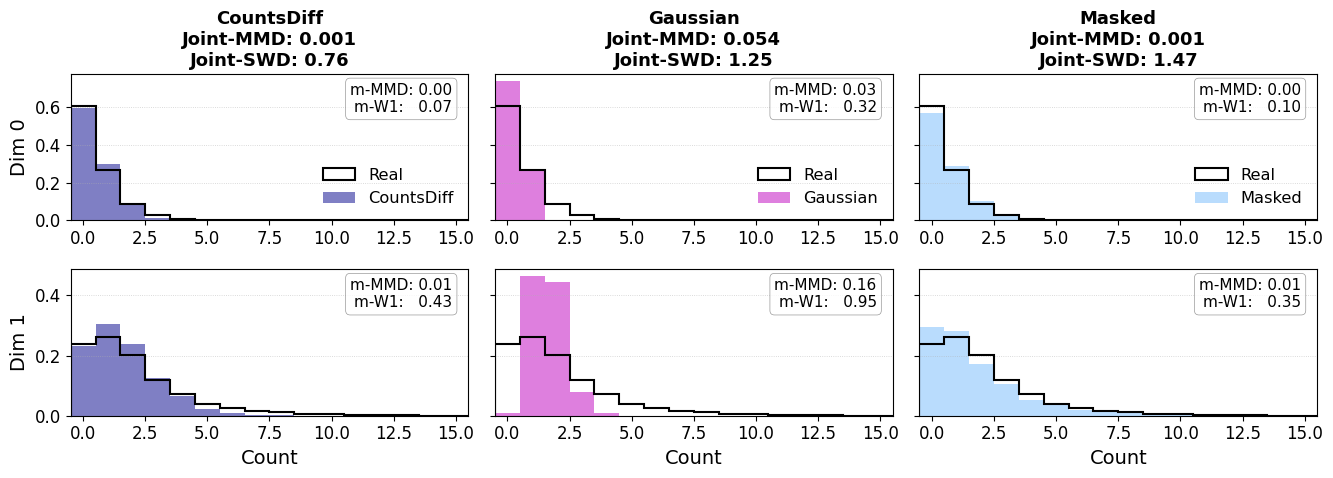

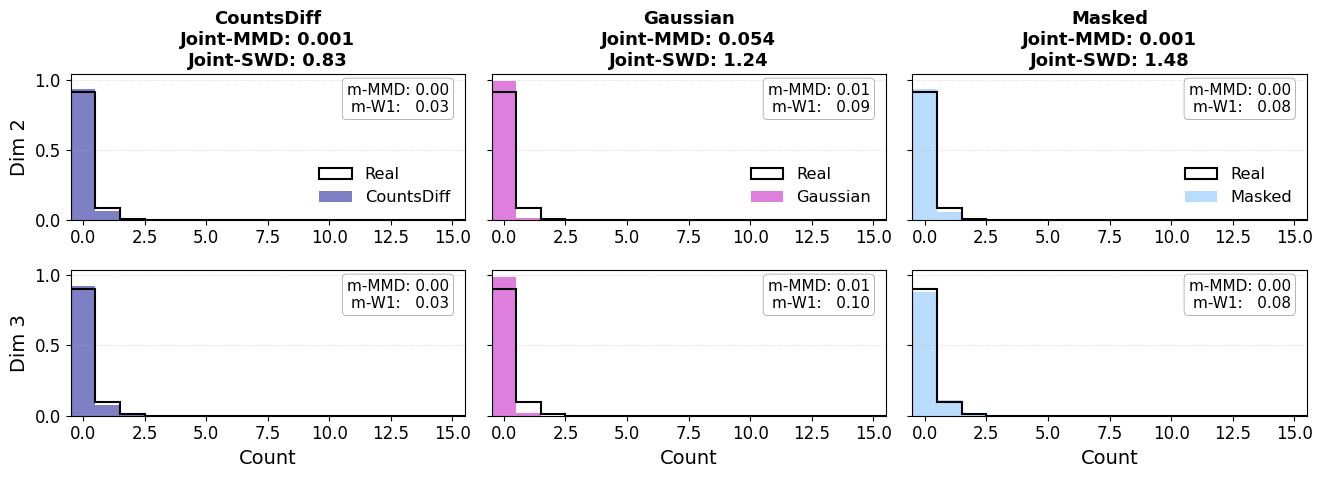

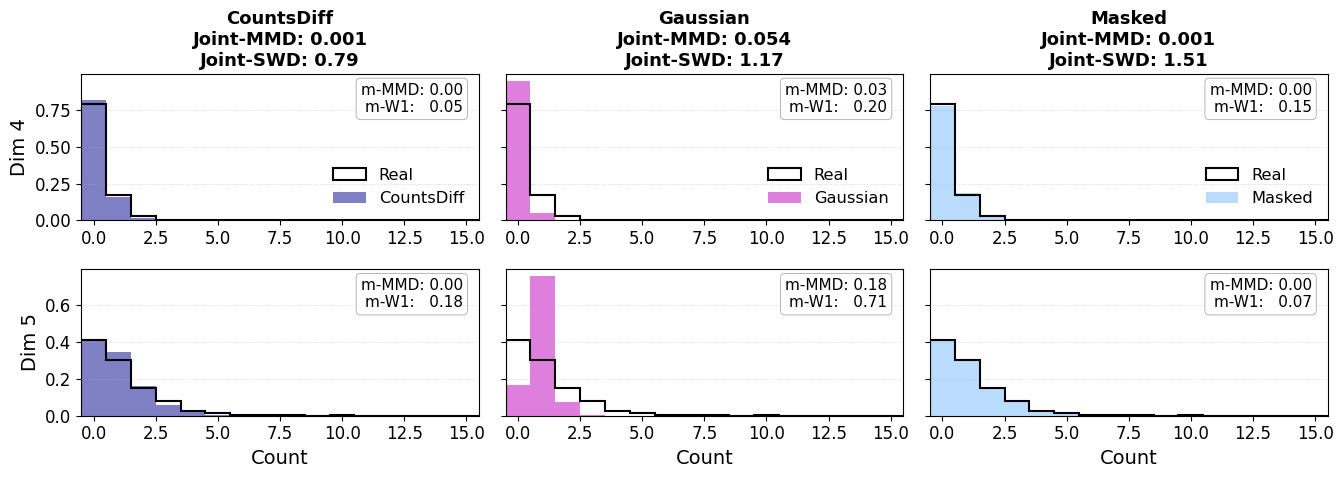

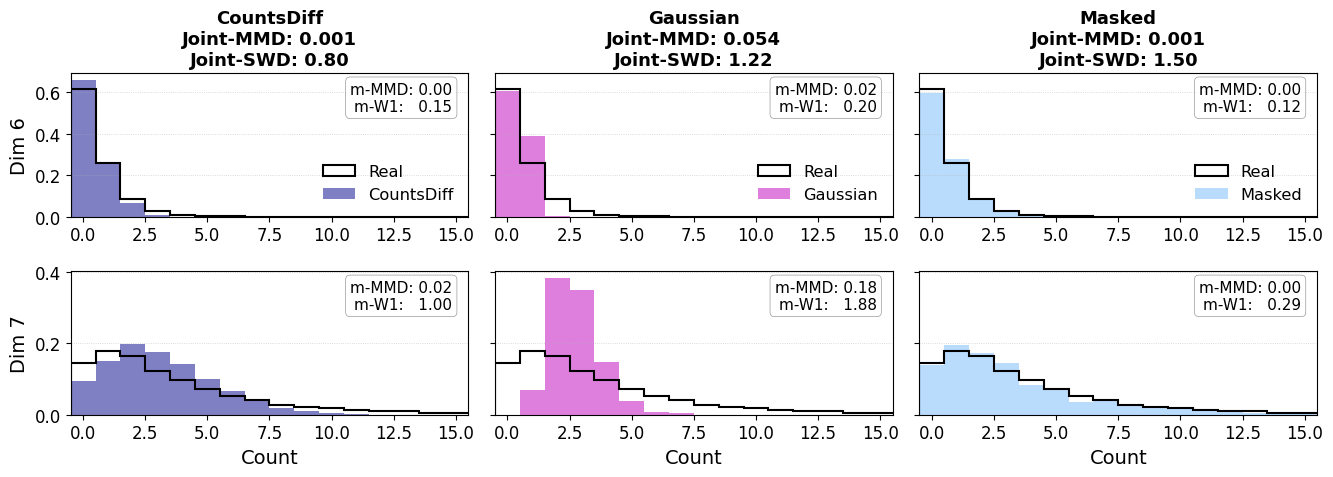

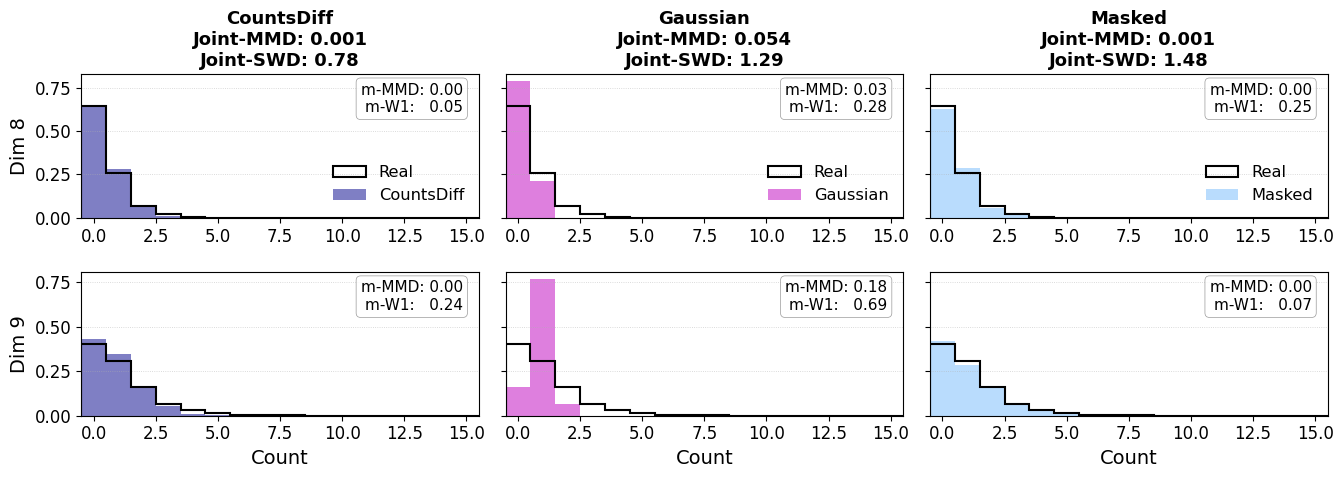

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import torch
from scipy.stats import wasserstein_distance

# ==========================================
# 1. Metric Helper Functions
# ==========================================

def sliced_wasserstein(real_np: np.ndarray, gen_np: np.ndarray, num_projections=100, device='cpu') -> float:
    """
    Computes Sliced Wasserstein Distance (SWD) to approximate Joint Wasserstein.
    Projects high-dim data to random 1D lines -> Sorts -> Computes L2 distance.
    """
    # Convert to torch
    real = torch.from_numpy(real_np).float().to(device)
    gen = torch.from_numpy(gen_np).float().to(device)

    # Check dimensions
    if real.shape[1] != gen.shape[1]:
        raise ValueError("Shape mismatch between real and gen data")
    
    dim = real.shape[1]
    
    # 1. Generate random projections (normalized)
    projections = torch.randn(num_projections, dim, device=device)
    projections = projections / torch.norm(projections, dim=1, keepdim=True)
    
    # 2. Project data [N, num_projections]
    real_proj = real @ projections.T
    gen_proj = gen @ projections.T
    
    # 3. Sort projections (SWD relies on sorting 1D distributions)
    real_proj_sorted, _ = torch.sort(real_proj, dim=0)
    gen_proj_sorted, _ = torch.sort(gen_proj, dim=0)
    
    # 4. Compute L2 distance averaged over projections
    diff = real_proj_sorted - gen_proj_sorted
    wd = torch.mean(torch.pow(diff, 2)) # MSE
    return torch.sqrt(wd).item()        # RMSE

def _marginal_wasserstein_per_dim(real_np: np.ndarray, gen_np: np.ndarray, dims):
    """
    Computes exact W1 distance per dimension using Scipy.
    """
    vals = []
    for d in dims:
        # Scipy's wasserstein_distance computes exact 1D Earth Mover's Distance
        w_d = wasserstein_distance(real_np[:, d], gen_np[:, d])
        vals.append(w_d)
    return np.asarray(vals, dtype=float)

def _joint_mmd(real_np: np.ndarray, gen_np: np.ndarray, **mmd_kwargs) -> float:
    # Assumes mmd() is defined globally or imported
    return mmd(torch.from_numpy(real_np), torch.from_numpy(gen_np), **mmd_kwargs)

def _marginal_mmd_per_dim(real_np: np.ndarray, gen_np: np.ndarray, dims, **mmd_kwargs):
    vals = []
    for d in dims:
        r = torch.from_numpy(real_np[:, d])
        g = torch.from_numpy(gen_np[:, d])
        vals.append(mmd(r, g, **mmd_kwargs))
    return np.asarray(vals, dtype=float)

# ==========================================
# 2. Main Plotting Function
# ==========================================

def plot_real_vs_models_grid(
    real, S_cd, S_g, S_abs,
    dims=None, page_size=10, start_page=0,
    mmd_kwargs=dict(kernel='rbf', gamma=1.0),
    annotate_mmd=True, # Toggle MMD text
    annotate_w=True    # Toggle Wasserstein text (SWD for Joint, W1 for Marginal)
):
    """
    Rows = dimensions, Cols = models.
    Overlays Real vs Model histograms.
    
    Annotations:
      - Titles: Joint MMD and/or Joint Sliced Wasserstein (SWD)
      - Subplots: Marginal MMD and/or Marginal W1
    """
    model_names  = ["CountsDiff", "Gaussian", "Masked"]
    model_arrays = [S_cd, S_g, S_abs]
    model_colors = ["darkblue", 'm', 'xkcd:sky blue']
    
    plt.rcParams.update({
        "font.size": 14, "axes.titlesize": 13, "axes.labelsize": 14,
        "legend.fontsize": 12, "xtick.labelsize": 12, "ytick.labelsize": 12
    })

    D = real.shape[1]
    if dims is None: dims = list(range(D))

    # Pagination
    n_pages = ceil(len(dims) / page_size)
    start = start_page * page_size
    end = min(start + page_size, len(dims))
    dims_page = dims[start:end]
    if not dims_page:
        raise ValueError(f"No dimensions to plot on page {start_page} (total pages: {n_pages}).")

    n_rows = len(dims_page)
    n_cols = len(model_arrays)

    # --- 1. Precompute JOINT Metrics (Once per model) ---
    joint_mmds = []
    joint_swds = []
    
    for arr in model_arrays:
        if annotate_mmd:
            joint_mmds.append(_joint_mmd(real, arr, **mmd_kwargs))
        if annotate_w:
            # Use Sliced Wasserstein for Joint
            joint_swds.append(sliced_wasserstein(real, arr, num_projections=500))

    # --- 2. Precompute MARGINAL Metrics (For dimensions on this page) ---
    marginal_mmds = []
    marginal_w1s = []
    
    for arr in model_arrays:
        if annotate_mmd:
            marginal_mmds.append(_marginal_mmd_per_dim(real, arr, dims_page, **mmd_kwargs))
        if annotate_w:
            # Use Exact W1 for Marginal
            marginal_w1s.append(_marginal_wasserstein_per_dim(real, arr, dims_page))

    # --- 3. Plotting ---
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(4.5 * n_cols, 2.5 * n_rows),
        sharex=False, sharey='row', squeeze=False
    )

    for r, dim in enumerate(dims_page):
        # Compute consistent bins for this row
        row_data = np.concatenate([real[:, dim]] + [m[:, dim] for m in model_arrays])
        row_max = int(np.max(row_data))
        bins = np.arange(0, row_max + 2) - 0.5
        xlim = (-0.5, 15.5) # Adjust as needed for your data scale

        for c, (name, marr, color) in enumerate(zip(model_names, model_arrays, model_colors)):
            ax = axes[r, c]
            
            # Histograms
            ax.hist(real[:, dim], bins=bins, density=True, histtype='step', linewidth=1.5, color='k', label='Real')
            ax.hist(marr[:, dim], bins=bins, density=True, histtype='stepfilled', alpha=0.5, color=color, label=name)

            # --- Titles (Joint Metrics) ---
            if r == 0:
                title_parts = [name]
                if annotate_mmd:
                    title_parts.append(f"Joint-MMD: {joint_mmds[c]:.3f}")
                if annotate_w:
                    title_parts.append(f"Joint-SWD: {joint_swds[c]:.2f}")
                
                # Join with newlines if too long, or separators
                ax.set_title("\n".join(title_parts), fontweight='bold', fontsize=13)

            # --- Axis Labels ---
            if c == 0: ax.set_ylabel(f"Dim {dim}")
            if r == n_rows - 1: ax.set_xlabel("Count")

            ax.set_xlim(*xlim)
            ax.grid(True, axis='y', linestyle=':', linewidth=0.6, alpha=0.6)

            # --- Annotations (Marginal Metrics) ---
            # We stack text in the top right
            stats_text = []
            if annotate_mmd:
                stats_text.append(f"m-MMD: {marginal_mmds[c][r]:.2f}")
            if annotate_w:
                stats_text.append(f"m-W1:   {marginal_w1s[c][r]:.2f}")
            
            if stats_text:
                ax.text(
                    0.96, 0.94, "\n".join(stats_text),
                    transform=ax.transAxes, ha='right', va='top',
                    fontsize=11,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, linewidth=0.5, edgecolor='gray')
                )

            # Legend (First plot only)
            if r == 0:
                ax.legend(loc='lower right', fontsize='small', frameon=False)

    plt.tight_layout()
    fig.savefig(f'real_vs_models_page_{start_page}.pdf', bbox_inches='tight')
    plt.show()
# Example usage (same as before):
plot_real_vs_models_grid(real, S_cd, S_g, S_abs, page_size=2, start_page=0)

plot_real_vs_models_grid(real, S_cd, S_g, S_abs, page_size=2, start_page=1)


plot_real_vs_models_grid(real, S_cd, S_g, S_abs, page_size=2, start_page=2)

plot_real_vs_models_grid(real, S_cd, S_g, S_abs, page_size=2, start_page=3)

plot_real_vs_models_grid(real, S_cd, S_g, S_abs, page_size=2, start_page=4)


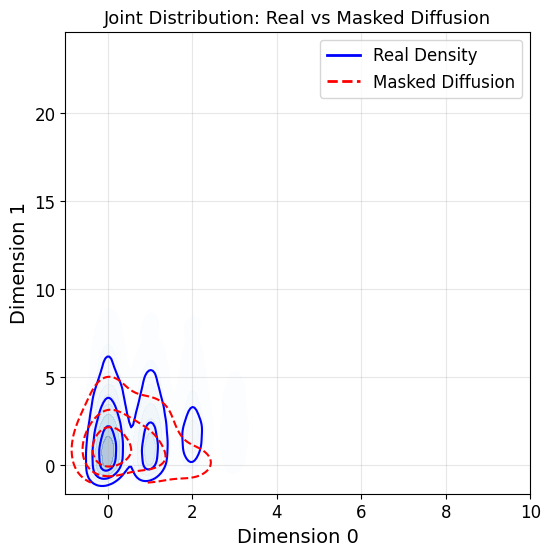

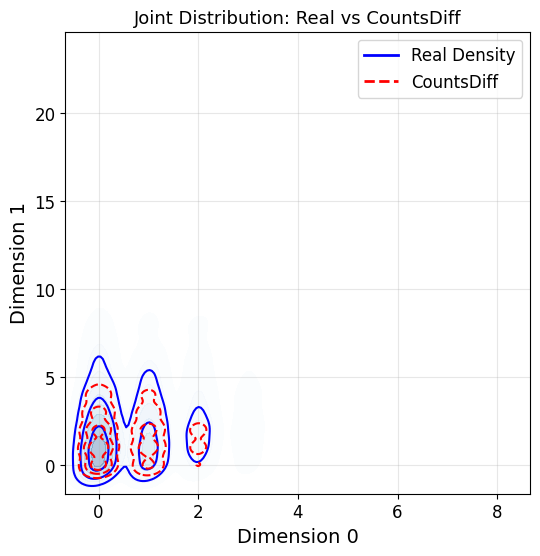

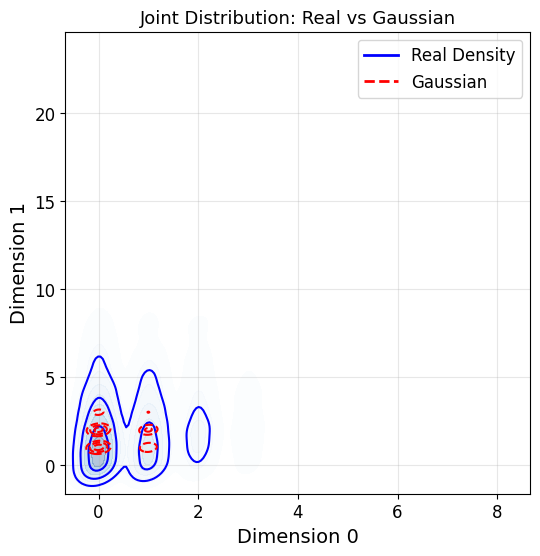

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_joint_kde(real, model, dim_x, dim_y, model_name="Model"):
    plt.figure(figsize=(6, 6))
    
    # 1. Plot Real Data (Filled + Outline)
    # We don't pass label here anymore because we will make a custom one
    sns.kdeplot(
        x=real[:, dim_x], y=real[:, dim_y],
        cmap="Blues", fill=True, thresh=0.05, alpha=0.3
    )
    sns.kdeplot(
        x=real[:, dim_x], y=real[:, dim_y],
        color="blue", levels=[0.2, 0.5, 0.8], linewidths=1.5
    )

    # 2. Plot Model Data (Red Dashed Outline)
    sns.kdeplot(
        x=model[:, dim_x], y=model[:, dim_y],
        color="red", levels=[0.2, 0.5, 0.8], linewidths=1.5, linestyles="--",
        clip=((-1, 10), (-1, 10)) # Optional clipping if needed
    )
    
    # 3. Create Proxy Artists for the Legend
    # This creates a "fake" blue line and a "fake" red dashed line 
    # that Matplotlib can use to draw the legend key.
    legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label='Real Density'),
        Line2D([0], [0], color='red', lw=2, linestyle='--', label=model_name)
    ]
    
    plt.xlabel(f"Dimension {dim_x}")
    plt.ylabel(f"Dimension {dim_y}")
    plt.title(f"Joint Distribution: Real vs {model_name}")
    plt.grid(True, alpha=0.3)
    
    # 4. Add the manual legend
    plt.legend(handles=legend_elements, loc='upper right')
    plt.savefig(f'joint_kde_{model_name}_dim{dim_x}_dim{dim_y}.pdf', bbox_inches='tight')
    plt.show()

# Example usage
plot_joint_kde(real, S_abs, dim_x=0, dim_y=1, model_name="Masked Diffusion")
plot_joint_kde(real, S_cd, dim_x=0, dim_y=1, model_name="CountsDiff")
plot_joint_kde(real, S_g, dim_x=0, dim_y=1, model_name="Gaussian")

In [ ]:
print("Variance per dim:")
for i in range(D):
    real_var = np.var(real[:, i])
    cd_var = np.var(S_cd[:, i])
    g_var = np.var(S_g[:, i])
    abs_var = np.var(S_abs[:, i])
    print(f"Dim {i}: Real={real_var:.2f}, CountsDiff={cd_var:.2f}, Gaussian={g_var:.2f}, Masked Diffusion={abs_var:.2f}")

Variance per dim:
Dim 0: Real=0.78, CountsDiff=0.55, Gaussian=0.19, Absorbing=3.06
Dim 1: Real=4.71, CountsDiff=1.99, Gaussian=0.46, Absorbing=9.22
Dim 2: Real=0.10, CountsDiff=0.07, Gaussian=0.01, Absorbing=1.89
Dim 3: Real=0.12, CountsDiff=0.08, Gaussian=0.02, Absorbing=2.49
Dim 4: Real=0.28, CountsDiff=0.21, Gaussian=0.05, Absorbing=7.27
Dim 5: Real=1.97, CountsDiff=1.10, Gaussian=0.24, Absorbing=4.78
Dim 6: Real=0.84, CountsDiff=0.44, Gaussian=0.24, Absorbing=5.19
Dim 7: Real=16.09, CountsDiff=4.50, Gaussian=1.04, Absorbing=19.83
Dim 8: Real=0.62, CountsDiff=0.46, Gaussian=0.17, Absorbing=11.63
Dim 9: Real=1.77, CountsDiff=0.96, Gaussian=0.22, Absorbing=4.09


# Rounding Strategies

In [133]:
n_samples = 2000
with torch.no_grad():
    real = val_loader.dataset.tensors[0].cpu().numpy()


    S_none = sample_countsdiff(countsdiff_model, n_samples=n_samples, n_steps=200, D=D, method='none').numpy()
    # CountsDiff deterministic_rounding
    S_stochastic = sample_countsdiff(countsdiff_model, n_samples=n_samples, n_steps=200, D=D, method='stochastic').numpy()

    S_poisson = sample_countsdiff(countsdiff_model, n_samples=n_samples, n_steps=200, D=D, method='poisson').numpy()
    


In [140]:
def plot_real_vs_models_grid(
    real, S_cd, S_g, S_abs,
    dims=None, page_size=10, start_page=0,
    mmd_kwargs=dict(kernel='rbf', gamma=1.0),
    annotate=True
):
    """
    Rows = dimensions, Cols = models (CountsDiff, Gaussian, Absorbing).
    Overlay Real (outline) vs model (filled). Optionally annotate:
      - Column titles: Joint MMD for each model.
      - Each subplot: Marginal (per-dim) MMD for that model & dimension.
    """
    model_names  = ["Standard", "Poisson", "Stochastic"]
    model_arrays = [S_cd, S_g, S_abs]
    model_colors = ["darkblue", 'm', 'xkcd:sky blue']
    
    plt.rcParams.update({
        "font.size": 14,       # base font size
        "axes.titlesize": 16,  # subplot titles
        "axes.labelsize": 14,  # axis labels
        "legend.fontsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12
    })

    D = real.shape[1]
    if dims is None:
        dims = list(range(D))

    # Pagination
    n_pages = ceil(len(dims) / page_size)
    start = start_page * page_size
    end = min(start + page_size, len(dims))
    dims_page = dims[start:end]
    if not dims_page:
        raise ValueError(f"No dimensions to plot on page {start_page} (total pages: {n_pages}).")

    n_rows = len(dims_page)
    n_cols = len(model_arrays)

    # Precompute JOINT MMDs (once per model)
    joint_mmds = None
    if annotate:
        joint_mmds = []
        for arr in model_arrays:
            joint_mmds.append(_joint_mmd(real, arr, **mmd_kwargs))

    # Precompute per-dim MMDs for the dims on this page (for each model)
    marginal_mmds = None
    if annotate:
        marginal_mmds = []
        for arr in model_arrays:
            marginal_mmds.append(_marginal_mmd_per_dim(real, arr, dims_page, **mmd_kwargs))
        # shape: [n_models, n_rows]

    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(4 * n_cols, 2.0 * n_rows),
        sharex=False, sharey='row', squeeze=False
    )

    for r, dim in enumerate(dims_page):
        # Row-wise bins/xlim consistent across columns for this dim
        row_max = int(np.max(np.concatenate([real[:, dim]] + [m[:, dim] for m in model_arrays])))
        bins = np.arange(0, row_max + 2) - 0.5
        xlim = (-0.5, 15.5)

        for c, (name, marr, color) in enumerate(zip(model_names, model_arrays, model_colors)):
            ax = axes[r, c]
            # Real (outline)
            ax.hist(real[:, dim], bins=bins, density=True, histtype='step', linewidth=1.2, color='k', label='Real')
            # Model (filled)
            ax.hist(marr[:, dim], bins=bins, density=True, histtype='stepfilled', alpha=0.5, color=color, label=name)

            # Column titles on top row; optionally include joint MMD
            if r == 0:
                    ax.set_title(name)
            

            # Row labels
            if c == 0:
                ax.set_ylabel(f"Dim {dim % 2 + 1}")
            if r == n_rows - 1:
                ax.set_xlabel("Count")

            ax.set_xlim(*xlim)
            ax.grid(True, axis='y', linestyle=':', linewidth=0.6, alpha=0.6)

            # Per-subplot marginal MMD annotation (top-right)
            if annotate and marginal_mmds is not None:
                mm = marginal_mmds[c][r]  # model c, row r
                ax.text(
                    0.98, 0.96, f"MMD: {mm:.3g}",
                    transform=ax.transAxes, ha='right', va='top',
                    fontsize=14,
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.6, linewidth=0.0)
                )

            # Legend only on first row, first column (saves space)
            if r == 0:
                ax.legend(loc='best', fontsize='small', frameon=False)

    plt.tight_layout()
    fig.savefig(f'sampling_schemes_page_{start_page}.pdf', bbox_inches='tight')
    plt.show()



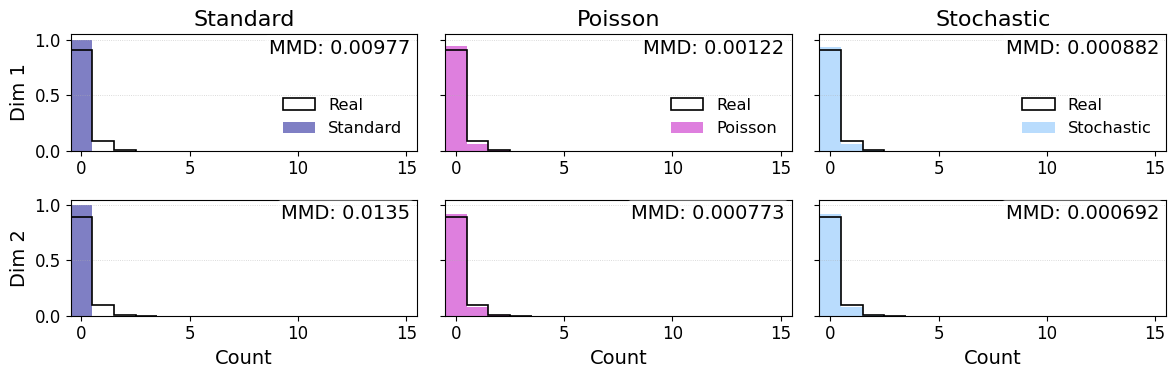

In [141]:
plot_real_vs_models_grid(real, S_none, S_poisson, S_stochastic, page_size=2, start_page=1)

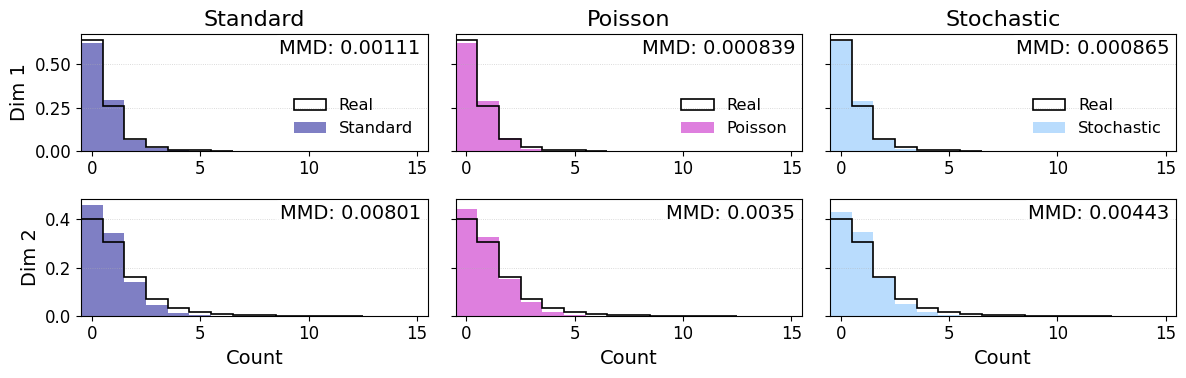

In [142]:
plot_real_vs_models_grid(real, S_none, S_poisson, S_stochastic, page_size=2, start_page=4)